Code queries - Lalitha Raghavan


# Create a Bayesian model for price optimization 

### References - https://austinrochford.com/posts/2021-06-10-lego-pymc3.html

### Used a Cauchy here - checked with Normal, not much of a difference in the results.

In [51]:
import pymc3 as pm
from pymc3 import  *
import theano
import theano.tensor as tt
print('Running on PyMC3 v{}'.format(pm.__version__))

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Running on PyMC3 v3.11.2


Testing the Bayesian model on Roller+Roller LB, SiSiC, Rodental Plant

Filtered data and extracted only these values to a different excel sheet, created a new column based on the weight per kg based off selling price and total weight sold.

Can customize model based on additional filters to use same sheet - need to code for that (didn't bother)


In [55]:
dff = dff[dff['Quantity'] > 0]
dff = dff[dff['Unit Price'] > 0]

Grouping the data to ensure that we capture total quantities sold for each individual price

In [56]:

df = dff.groupby(['Unit Price'])['Quantity'].sum().reset_index()

p0 = df['Unit Price']
d0 = df['Quantity']

In [57]:
len(df)

42

## Cauchy priors

Normally price distribution is written as Q=aP^c where Q is the quantity sold, P is the price, c is the constant price elasticity (usually negative) and a is the function describing the relation between Q and P. There we take a log to ease out the equation and for reparameterization (wiki this - not easy to understand but in a broad sense you are rewriting the equation to remove long tailedness, high correlations)

In [32]:

with pm.Model() as m:
    α = pm.Cauchy('α',0,5)
    β = pm.Cauchy('β',0,5)
    logμ0 = α + β * (np.log(p0) - np.log(p0).mean())   ## Mean values are taken to remove off center values and reparameterization - Took this equation from tutorials
    μ0 = pm.Deterministic('μ0',np.exp(logμ0))
    qval = pm.Poisson('q0',μ0,observed=d0)

Now we extract values from the posterior using MCMC sampling method 

Markov Chain Monte Carlo provides an alternate approach to random sampling a high-dimensional probability distribution where the next sample is dependent upon the current sample. (Ref: https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/)

In [33]:
with m:
    trace = pm.sample(8000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\L7927301\Documents\Projects\Global Pricing\bayesian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\L7927301\Documents\Projects\Global Pricing\bayesian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 88 seconds.


In [34]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.232,0.010,7.213,7.250,0.000,0.000,10486.0,14771.0,1.0
β,-11.796,0.091,-11.963,-11.620,0.001,0.001,9891.0,13941.0,1.0
μ0[0],8883.837,85.326,8727.024,9047.139,0.618,0.437,19066.0,21425.0,1.0
μ0[1],3615.132,23.960,3570.422,3660.910,0.157,0.111,23385.0,23615.0,1.0
μ0[2],2817.127,19.423,2781.043,2854.081,0.150,0.106,16843.0,21065.0,1.0
μ0[3],2320.867,17.281,2288.703,2353.749,0.147,0.104,13758.0,18233.0,1.0
μ0[4],1506.517,14.224,1479.144,1532.506,0.137,0.097,10743.0,15282.0,1.0
μ0[5],1103.838,12.446,1079.719,1126.450,0.124,0.088,10010.0,13845.0,1.0
μ0[6],934.370,11.528,912.698,955.783,0.116,0.082,9802.0,13638.0,1.0
μ0[7],759.133,10.412,739.649,778.515,0.106,0.075,9640.0,13115.0,1.0


In the above, each Mu value corresponds to a different price point. 

we now plot the trace - columns on the left indicate similarties. If the shape of each independent variable does not overlap significantly, it means our sampling is wrong. In the below chart, it seems to overlap pretty well and the auto-correlation in the right hand columns also indicate that the sampling technique is ok to proceed with

C:\Users\L7927301\AppData\Local\Temp/ipykernel_8620/2777670638.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


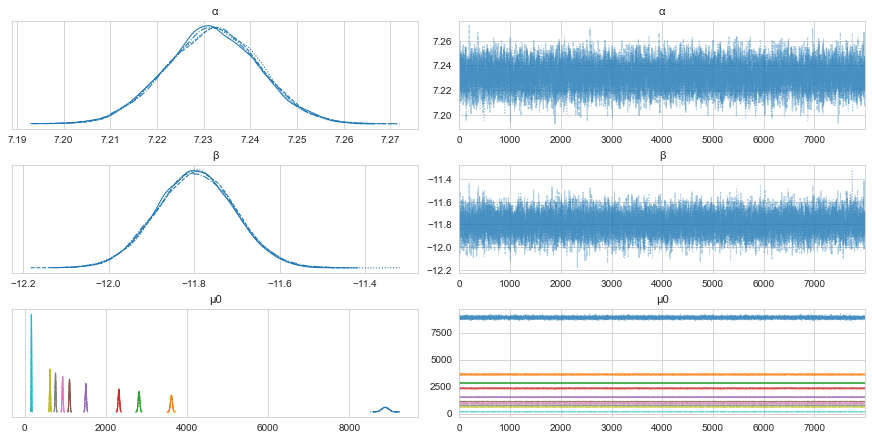

In [35]:
pm.traceplot(trace);

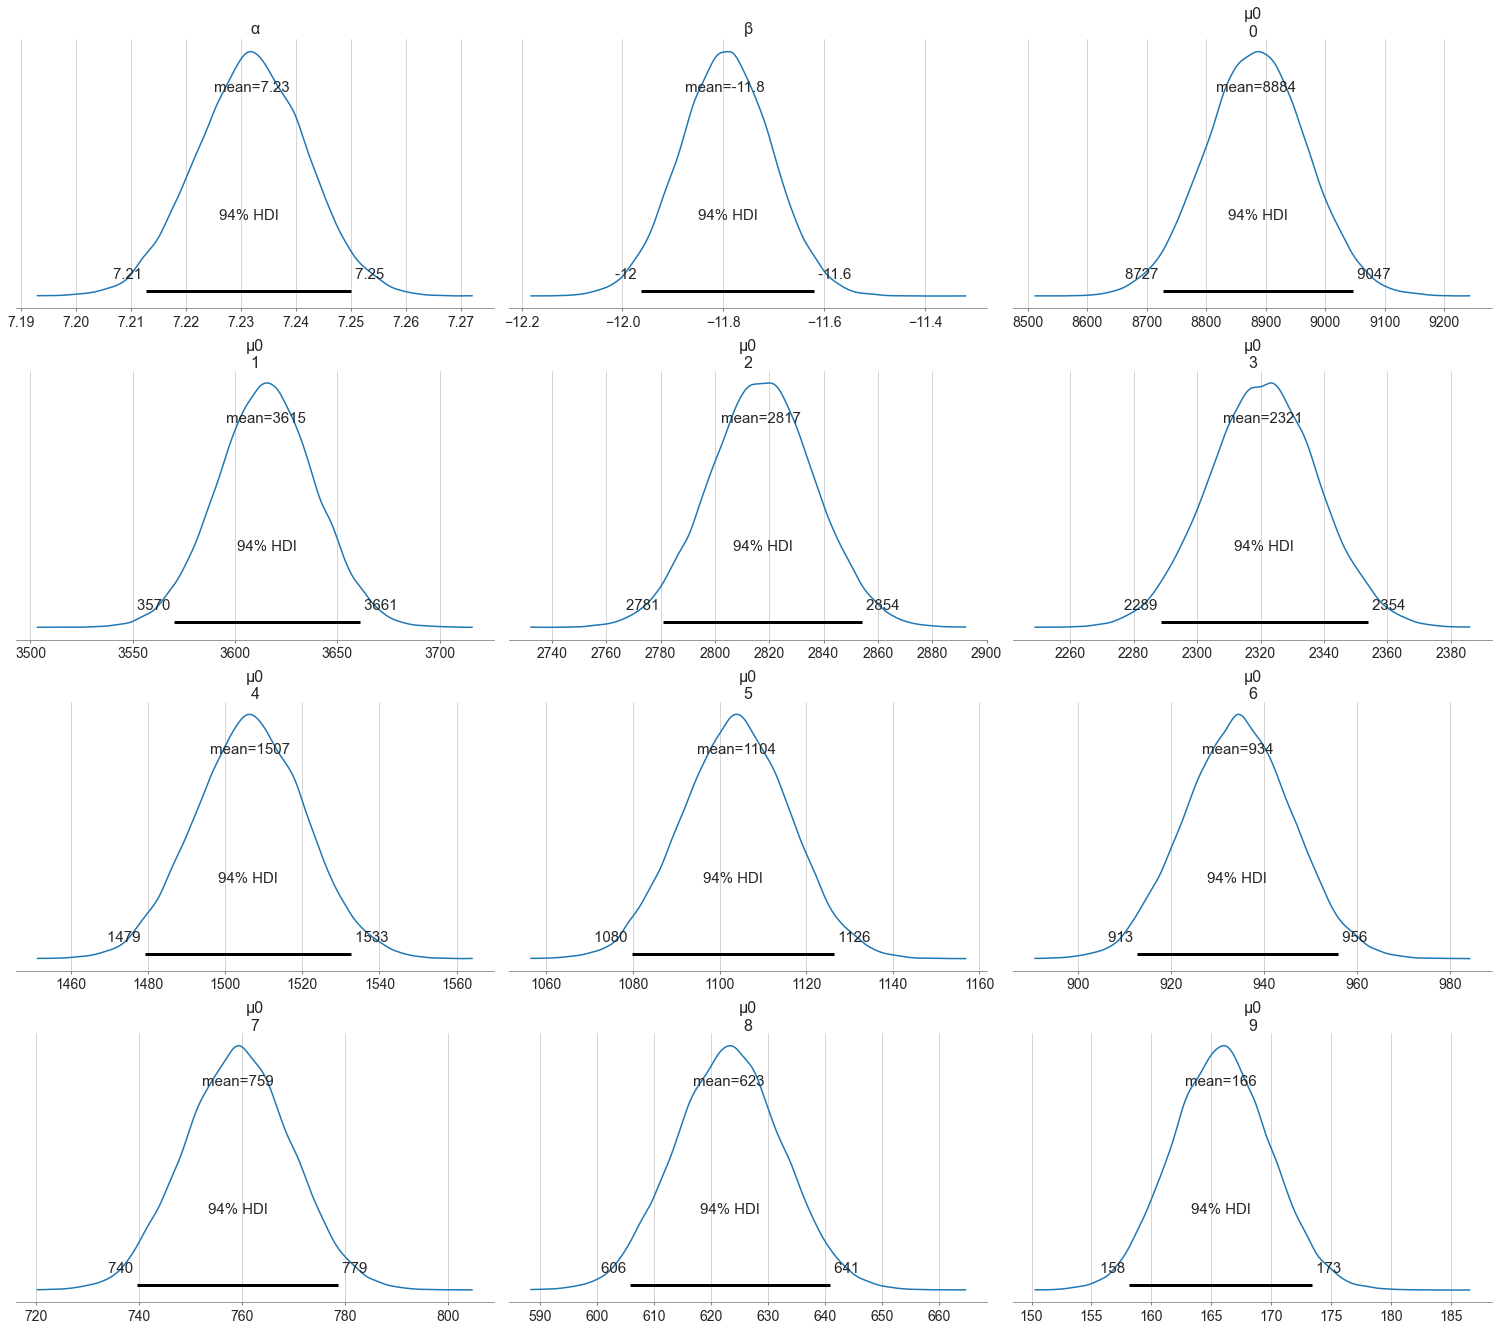

In [36]:
plot_posterior(trace, round_to=3)
plt.show()

### Plotting from the posterior threads

Each black line below is a sample we have derived from the posterior checks. The red dots represent actual data points. The points that lie outside of the black lines are probably outliers. We may choose more sampling to be sure (** will run checks for this and run a larger sampliing size)

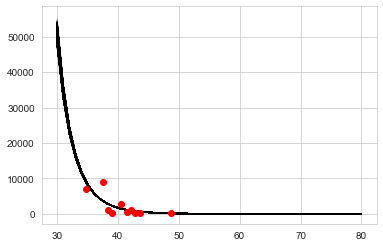

In [37]:
p = np.linspace(30,80)
μ = np.exp(trace.α + trace.β * (np.log(p).reshape(-1,1) - np.log(p0).mean()))
plt.plot(p,μ,c='k',alpha=0.01);
plt.plot(p0,d0,'o',c='r');

In [38]:
k = 32.49 ## Use 32.49 for complexity 2 and 32.38 for complexity 1
π = (p - k).reshape(-1,1) * μ

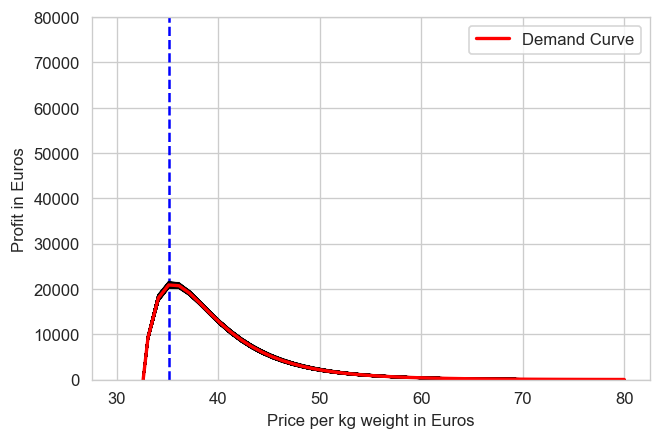

In [39]:
plt.rcParams['figure.dpi'] = 120
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(p,np.mean(π,1).T,c='red',lw=2,label="Demand Curve");
pmax = p[np.argmax(np.mean(π,1))]
plt.vlines(pmax,0,80000,colors='blue',linestyles='dashed')
plt.ylim(0,80000);
plt.xlabel("Price per kg weight in Euros")
plt.ylabel("Profit in Euros")

plt.legend();

### Optimum profit calculation 
The way we do this is by maximizing profit. Recall that:
Profit = (Total sale - Fixed costs)*Mu   *** we used this equation above ((π = (p - k).reshape(-1,1) * μ))

Check page 7 of Ref https://www.andrew.cmu.edu/user/alm3/papers/informative%20prior.pdf

In [40]:
b = np.mean(trace.β)  
p_opt_mean = k/(1+(1/b))  ## If we have a b value approaching -1, our values would no longer make sense. Hence taking a median value is better (Ref: https://www.johndcook.com/blog/cauchy_estimation/)
p_opt_mean


35.49937046367602

In [41]:
b2 = np.median(trace.β)
p_opt_median = k/(1+(1/b2))
p_opt_median

35.49943586886086

In [42]:
pmax

35.10204081632653

In [43]:
## Trying OLS

In [44]:
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

c:\Users\L7927301\Documents\Projects\Global PCR Pricing\bayesian\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


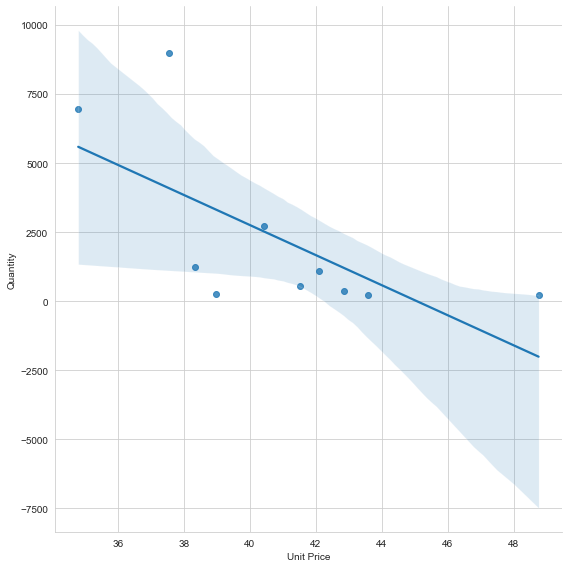

In [45]:
sns.lmplot(x = "Unit Price", y = "Quantity", 
data = df, size = 8)

In [46]:
# fit OLS model
model = ols("d0 ~ p0", data = df).fit()
# print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     d0   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     6.393
Date:                Tue, 09 Nov 2021   Prob (F-statistic):             0.0353
Time:                        16:25:00   Log-Likelihood:                -91.265
No. Observations:                  10   AIC:                             186.5
Df Residuals:                       8   BIC:                             187.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.453e+04   8837.423      2.776      0.0

c:\Users\L7927301\Documents\Projects\Global PCR Pricing\bayesian\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [48]:
# plugging regression coefficients
quantity = 2.453e+04 - 544.2606 * p0 # eq (5)
# the profit function in eq (3) becomes
profit = (2.453e+04 - 544.2606 * p0) * p0 - k # eq (6)

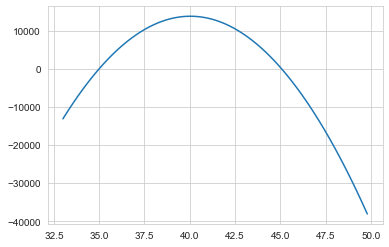

In [49]:
# a range of diffferent prices to find the optimum one
Price = np.arange(33, 50, 0.2)
# assuming a fixed cost
cost = 35
Revenue = []
for i in Price:
   quantity_demanded = 2.453e+04 - 544.2606 * i
   
   # profit function
   Revenue.append((i-cost) * quantity_demanded)
# create data frame of price and revenue
profit = pd.DataFrame({"Price": Price, "Revenue": Revenue})
#plot revenue against price
plt.plot(profit["Price"], profit["Revenue"])

In [50]:
# price at which revenue is maximum
profit.loc[profit['Revenue'].idxmax()]

Price         40.00
Revenue    13797.88
Name: 35, dtype: float64

In [1]:
#Complexity 1 		€43.93 per kg
#Complexity 2 		€35.49 per kg
